# BigQuery, Pandas 예제  
노트북 작성: 박상길 <skpark1224@hyundai.com>  
inspired by a book called  
『Google BigQuery: The Definitive Guide: Data Warehousing, Analytics, and Machine Learning at Scale』

런던의 전체 자전거 대여소의 사용 횟수와 평균 사용 시간을 추출해보자.

In [4]:
%%bigquery df
SELECT 
  start_station_name 
  , AVG(duration) as duration
  , COUNT(duration) as num_trips
FROM `bigquery-public-data`.london_bicycles.cycle_hire 
GROUP BY start_station_name
ORDER BY num_trips DESC

In [5]:
df

,start_station_name,duration,num_trips
0,"Belgrove Street , King's Cross",1011.076696,234458
1,"Hyde Park Corner, Hyde Park",2782.730709,215629
2,"Waterloo Station 3, Waterloo",866.376135,201630
3,"Black Lion Gate, Kensington Gardens",3588.012004,161952
4,"Albert Gate, Hyde Park",2359.413930,155647
...,...,...,...
875,Monier Road,1576.363636,11
876,"Blackfriars road, Southwark",96.000000,5
877,LSP2,105.000000,4
878,PENTON STREET COMMS TEST TERMINAL _ CONTACT MA...,0.000000,1


In [6]:
df.describe()

,duration,num_trips
count,880.000000,880.000000
mean,1348.351153,27692.273864
std,434.057829,23733.621289
min,0.000000,1.000000
25%,1078.684974,13033.500000
50%,1255.889223,23658.500000
75%,1520.504055,35450.500000
max,4836.380090,234458.000000


다음과 같이 산점도(scatter plot)로 표현할 수 있다.

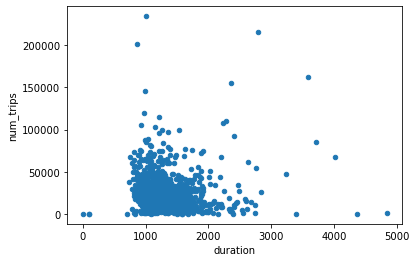

In [7]:
df.plot.scatter('duration', 'num_trips')

만일 누군가 어떤 대여소에서 자전거를 빌린 지 10분도 채 되지 않아 다시 원래 대여소로 되돌려 놓았다면 아마도 그 자전거에 문제가 있었기 때문이라고 추정할 수 있다. 이런 상황을 망친 나들이(bad trips)라 부르기로 하고 추출을 시도해보자.

In [10]:
%%bigquery badtrips
WITH all_bad_trips AS (
    SELECT 
      start_station_name
      , COUNTIF(duration < 600 AND start_station_name = end_station_name) AS bad_trips
      , COUNT(*) as num_trips
    FROM `bigquery-public-data`.london_bicycles.cycle_hire
    WHERE EXTRACT(YEAR FROM start_date) = 2015
    GROUP BY start_station_name
    HAVING num_trips > 10
)
SELECT *, bad_trips / num_trips AS fraction_bad FROM all_bad_trips
ORDER BY fraction_bad DESC

In [11]:
badtrips

,start_station_name,bad_trips,num_trips,fraction_bad
0,"Contact Centre, Southbury House",20,48,0.416667
1,"Monier Road, Newham",1,25,0.040000
2,"Aberfeldy Street, Poplar",35,955,0.036649
3,"Ormonde Gate, Chelsea",315,8932,0.035266
4,"Thornfield House, Poplar",28,947,0.029567
...,...,...,...,...
818,"Sun Street, Liverpool Street",70,28787,0.002432
819,"Finsbury Circus, Liverpool Street",100,44822,0.002231
820,"Waterloo Station 3, Waterloo",151,80916,0.001866
821,"Waterloo Roundabout, Waterloo",3,1678,0.001788


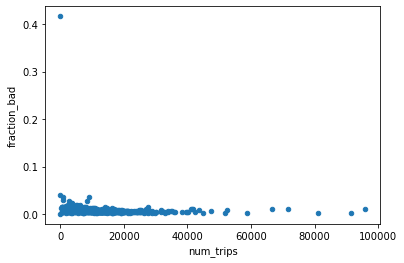

In [12]:
badtrips.plot.scatter('num_trips', 'fraction_bad')

이 그래프를 보면 fraction_bad 컬럼의 값이 높을수록 관련된 대여소의 num_trips 컬럼 값이 낮다는 점을 알 수 있지만 0.4라는 예외 때문에 그 트렌드가 명확하게 보이지 않는다. 다음 seaborn 패키지를 이용해서 데이터를 조금 더 자세히 들여다보자.

`regplot` do Plot the data and draw a linear regression model.

(0.0, 0.05)

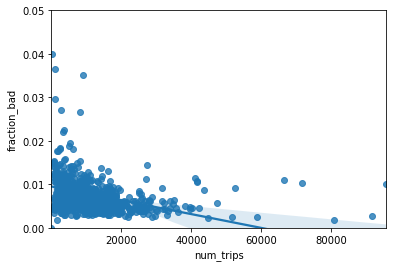

In [13]:
import seaborn as sns
ax = sns.regplot(badtrips['num_trips'],badtrips['fraction_bad'])
ax.set_ylim(0, 0.05)

이제 num_trips 컬럼 값이 낮은 대여소일수록 fraction_bad 컬럼 값이 높다는 점이 명확해졌다.

그런데, fraction_bad 값이 높을수록 num_trips 값이 낮으므로 단순히 fraction_bad 값이 높은 대여소로 직원을 보내서는 안된다. 그렇다면 임의 조사를 수행할 대여소를 어떻게 골라야 할까?

한 가지 방법은 사용 빈도가 높은 대여소 중에서 상황이 좋지 않은 5곳을 선택하고, 그 다음으로 사용 빈도가 높은 대여소 중 5곳을 선택해 나가는 방법이다. 그러려면 num_trips 컬럼 값을 기준으로 대여소의 변위치(quantile)을 구해 4개의 묶음(band)을 만들고, 각 묶음 안에서 망친 나들이 비율이 가장 높은 5개의 대여소를 찾으면 된다.

In [29]:
stations_to_examine = []
for band in range(1,5):
  min_trips = badtrips['num_trips'].quantile(0.2*(band))
  max_trips = badtrips['num_trips'].quantile(0.2*(band+1))
  query = 'num_trips >= {} and num_trips < {}'.format(
                                     min_trips, max_trips)
  print(query) # band
  stations = badtrips.query(query)
  stations = stations.sort_values(
                  by=['fraction_bad'], ascending=False)[:5] 
  print(stations) # 5 worst
  stations_to_examine.append(stations)
  print()

num_trips >= 4826.4 and num_trips < 8511.8
                 start_station_name  bad_trips  num_trips  fraction_bad
6        River Street , Clerkenwell        221       8279      0.026694
9   Courland Grove, Wandsworth Road        105       5369      0.019557
10         Stanley Grove, Battersea         92       4882      0.018845
12              Southern Grove, Bow        112       6152      0.018205
18    Richmond Way, Shepherd's Bush        126       8149      0.015462

num_trips >= 8511.8 and num_trips < 11502.6
                  start_station_name  bad_trips  num_trips  fraction_bad
3              Ormonde Gate, Chelsea        315       8932      0.035266
41  Emperor's Gate, South Kensington        136      10554      0.012886
53     Chepstow Villas, Notting Hill        135      11038      0.012230
57            Salmon Lane, Limehouse        113       9345      0.012092
63       Greyhound Road, Hammersmith        118       9998      0.011802

num_trips >= 11502.6 and num_trips < 1650

In [30]:
import pandas as pd

stations_to_examine = pd.concat(stations_to_examine)
stations_to_examine.head(5)

,start_station_name,bad_trips,num_trips,fraction_bad
6,"River Street , Clerkenwell",221,8279,0.026694
9,"Courland Grove, Wandsworth Road",105,5369,0.019557
10,"Stanley Grove, Battersea",92,4882,0.018845
12,"Southern Grove, Bow",112,6152,0.018205
18,"Richmond Way, Shepherd's Bush",126,8149,0.015462


이 데이터를 추후 보고서 작성을 위해 별도 테이블로 저장한다.

In [31]:
from google.cloud import bigquery

PROJECT='myhyundai20'
bq = bigquery.Client(project=PROJECT)

table_id = '{}.experiments.bad_bikes'.format(PROJECT)
job = bq.load_table_from_dataframe(stations_to_examine, table_id)
job.result() # blocks and waits
print("Loaded {} rows into {}".format(job.output_rows, table_id))

Loaded 20 rows into myhyundai20.experiments.bad_bikes


이제 저장한 대여소 위치를 위경도를 지닌 테이블과 조인하여 지도에 표현해본다.

In [35]:
%%bigquery stations_to_examine
SELECT 
  start_station_name AS station_name
  , num_trips
  , fraction_bad
  , latitude
  , longitude
FROM `myhyundai20`.experiments.bad_bikes AS bad
JOIN `myhyundai20`.experiments.cycle_stations AS s
ON bad.start_station_name = s.name

In [38]:
stations_to_examine.head(5)

,station_name,num_trips,fraction_bad,latitude,longitude
0,"Ormonde Gate, Chelsea",8932,0.035266,51.487964,-0.161765
1,"Stanley Grove, Battersea",4882,0.018845,51.470475,-0.152130
2,"Courland Grove, Wandsworth Road",5369,0.019557,51.472918,-0.132103
3,"Southern Grove, Bow",6152,0.018205,51.523538,-0.030556
4,"Salmon Lane, Limehouse",9345,0.012092,51.514115,-0.033828


folium 패키지를 이용해 지도에 표현해보자.

In [39]:
import folium
map_pts = folium.Map(location=[51.5, -0.15], zoom_start=12)
for idx, row in stations_to_examine.iterrows():
  folium.Marker( location=[row['latitude'], row['longitude']], popup=row['station_name'] ).add_to(map_pts)
map_pts

이제 이 대여소 위치에 직원을 보내서 대여소를 점검하자.